# EECS 442 FINAL: Geoguessr Neural Network

## Setup

In [1]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import math
import torch.nn as nn
import torchvision.models as models

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
Mount the cwd to drive, access the train folder and load the images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install gitpython > /dev/null 2>&1
# !apt-get install -y -qq git > /dev/null 2>&1

import os
import glob
import random
from PIL import Image


# print(os.getcwd())
# ! ls
# ! cd drive/MyDrive/442final
# print(os.getcwd())

data_directory = "/drive/MyDrive/442final/train/resized_countries_reshape"

batch_size = 32
img_width = 148
img_height = 64
epochs = 30

img_target_scale = 0.2
img_target_width = int(math.floor(img_width * img_target_scale))
img_target_height= int(math.floor(img_height * img_target_scale))

class get_Images(Dataset):
  def __init__(self, root_dir, split='train', percentage=0.7, transform=None):
    """
    Args:
        root_dir: the directory of the dataset
        split: "train" or "val"
        transform: pytorch transformations.
    """
    self.files = []
    self.labels = []

    # if split=='val':
    #   percentage = 1 - percentage

    self.transform = transform
    print(root_dir)
    for idx, country in enumerate(os.listdir(root_dir)):
      print(idx, end=' ')
      # Check if the item is a directory
      files_in_dir = np.load(root_dir+'/'+country).astype(np.float32)
      # print(files_in_dir.dtype)
      # Randomly sample a certain percentage of files
      num_files_to_take = int(len(files_in_dir) * percentage)
      # Append the sampled file paths to the list
      if split=='train':
        self.files.extend(files_in_dir[:num_files_to_take])
      else:
        num_files = len(files_in_dir)
        self.files.extend(files_in_dir[num_files - num_files_to_take:])

      # self.files.extend(glob.glob(os.path.join(root_dir, country, '*.jpg')))
      self.labels.extend([idx] * num_files_to_take)
    print()
    print(len(self.files))
    print(len(self.labels))
  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    # img_path = self.files[idx]
    label = self.labels[idx]
    # img = Image.open(img_path)
    # if self.transform:
    #     img = self.transform(img)
    return {'image': self.files[idx], 'label': label}

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

###########################################################################
# TODO: Construct the dataloader                                          #
# For the train_loader, please use a batch size of 4 and set shuffle True #
# For the val_loader, please use a batch size of 5 and set shuffle False  #
# Hint: You'll need to create instances of the class above, name them as  #
# tr_dt and te_dt. The dataloaders should be named as train_loader and    #
# test_loader. You also need to include transform in your class           #
#instances                                                                #
###########################################################################

tr_dt = get_Images(os.getcwd() + data_directory, split='train', percentage=0.7,  transform=transform)
te_dt = get_Images(os.getcwd() + data_directory, split='val', percentage=0.2, transform=transform)

train_loader = DataLoader(tr_dt, batch_size=32, shuffle=True)
test_loader = DataLoader(te_dt, batch_size=32, shuffle=False)

###########################################################################
#                              END OF YOUR CODE                           #
###########################################################################

print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

print("Done!")

Mounted at /content/drive
/content/drive/MyDrive/442final/train/resized_countries_reshape
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
25160
25160
/content/drive/MyDrive/442final/train/resized_countries_reshape
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 
7171
7171
Number of training images 25160, number of testing images 7171
Done!


## Model
CHANGE THIS TO GET THE MODEL TO RUN

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained DenseNet121
        self.densenet = models.densenet121(pretrained=True)
        # Freeze all layers
        for param in self.densenet.parameters():
            param.requires_grad = True
        # Extract the first n layers
        self.features = nn.Sequential(
            *list(self.densenet.features.children())[:60],
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.Linear(512, 55)
            )

    def forward(self, x):
        return self.densenet(x)

# Instantiate the model
model = Network()

# Set up optimization hyperparameters
learning_rate, weight_decay, num_epoch = 0.001, 1e-12, 30
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)


Network(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [8]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        # print(len(tqdm(trainloader)))
        # for i in tqdm(trainloader):
        #   print(i)
        for input in tqdm(trainloader):
            # print(batch, label)
            # print(batch)
            batch, label = input['image'], input['label']
            # print(batch)
            # print(label)
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for input in tqdm(loader):
            batch, label = input['image'], input['label']
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader,
                                                  test_loader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
# evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 787/787 [01:07<00:00, 11.63it/s]



 Epoch 1 loss:3.3734377612001256


100%|██████████| 787/787 [00:19<00:00, 39.91it/s]



 Evaluation accuracy: 0.2292925278219396

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.39it/s]



 Evaluation accuracy: 0.21977409008506485
-----------------Epoch = 2-----------------


100%|██████████| 787/787 [01:02<00:00, 12.63it/s]



 Epoch 2 loss:3.411657375483531


100%|██████████| 787/787 [00:19<00:00, 39.93it/s]



 Evaluation accuracy: 0.15385532591414944

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 40.20it/s]



 Evaluation accuracy: 0.15144331334541905
-----------------Epoch = 3-----------------


100%|██████████| 787/787 [01:02<00:00, 12.59it/s]



 Epoch 3 loss:3.023878414415798


100%|██████████| 787/787 [00:19<00:00, 41.41it/s]



 Evaluation accuracy: 0.2503577106518283

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 36.72it/s]



 Evaluation accuracy: 0.24041277367173336
-----------------Epoch = 4-----------------


100%|██████████| 787/787 [01:02<00:00, 12.61it/s]



 Epoch 4 loss:2.8113798348391676


100%|██████████| 787/787 [00:19<00:00, 39.83it/s]



 Evaluation accuracy: 0.28696343402225755

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 40.46it/s]



 Evaluation accuracy: 0.25714684144470784
-----------------Epoch = 5-----------------


100%|██████████| 787/787 [01:02<00:00, 12.53it/s]



 Epoch 5 loss:2.6386446869509648


100%|██████████| 787/787 [00:20<00:00, 38.69it/s]



 Evaluation accuracy: 0.3300476947535771

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 42.92it/s]



 Evaluation accuracy: 0.29368288941570214
-----------------Epoch = 6-----------------


100%|██████████| 787/787 [01:02<00:00, 12.55it/s]



 Epoch 6 loss:2.5009163584763696


100%|██████████| 787/787 [00:19<00:00, 40.05it/s]



 Evaluation accuracy: 0.36192368839427663

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 39.95it/s]



 Evaluation accuracy: 0.3198995955933622
-----------------Epoch = 7-----------------


100%|██████████| 787/787 [01:02<00:00, 12.57it/s]



 Epoch 7 loss:2.3783427782858495


100%|██████████| 787/787 [00:19<00:00, 40.60it/s]



 Evaluation accuracy: 0.3837440381558029

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 35.89it/s]



 Evaluation accuracy: 0.3194812438990378
-----------------Epoch = 8-----------------


100%|██████████| 787/787 [01:01<00:00, 12.73it/s]



 Epoch 8 loss:2.2570565472412594


100%|██████████| 787/787 [00:19<00:00, 39.65it/s]



 Evaluation accuracy: 0.3911764705882353

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.35it/s]



 Evaluation accuracy: 0.31976014502858735
-----------------Epoch = 9-----------------


100%|██████████| 787/787 [01:02<00:00, 12.53it/s]



 Epoch 9 loss:2.1509924121248374


100%|██████████| 787/787 [00:20<00:00, 39.23it/s]



 Evaluation accuracy: 0.4559220985691574

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.19it/s]



 Evaluation accuracy: 0.354762236787059
-----------------Epoch = 10-----------------


100%|██████████| 787/787 [01:02<00:00, 12.55it/s]



 Epoch 10 loss:2.022414887421013


100%|██████████| 787/787 [00:19<00:00, 41.27it/s]



 Evaluation accuracy: 0.4909379968203498

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 36.20it/s]



 Evaluation accuracy: 0.3465346534653465
-----------------Epoch = 11-----------------


100%|██████████| 787/787 [01:02<00:00, 12.55it/s]



 Epoch 11 loss:1.8978533844784224


100%|██████████| 787/787 [00:19<00:00, 41.17it/s]



 Evaluation accuracy: 0.5096184419713832

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 40.31it/s]



 Evaluation accuracy: 0.3394226746618324
-----------------Epoch = 12-----------------


100%|██████████| 787/787 [01:02<00:00, 12.60it/s]



 Epoch 12 loss:1.7814902813189215


100%|██████████| 787/787 [00:19<00:00, 39.53it/s]



 Evaluation accuracy: 0.553577106518283

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 42.24it/s]



 Evaluation accuracy: 0.35280992888021195
-----------------Epoch = 13-----------------


100%|██████████| 787/787 [01:02<00:00, 12.50it/s]



 Epoch 13 loss:1.6522278589547967


100%|██████████| 787/787 [00:19<00:00, 40.24it/s]



 Evaluation accuracy: 0.6005564387917329

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 39.64it/s]



 Evaluation accuracy: 0.34932366476084226
-----------------Epoch = 14-----------------


100%|██████████| 787/787 [01:02<00:00, 12.53it/s]



 Epoch 14 loss:1.5159202675504333


100%|██████████| 787/787 [00:19<00:00, 41.34it/s]



 Evaluation accuracy: 0.6416136724960254

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 36.68it/s]



 Evaluation accuracy: 0.34541904894714826
-----------------Epoch = 15-----------------


100%|██████████| 787/787 [01:01<00:00, 12.79it/s]



 Epoch 15 loss:1.3809704391292876


100%|██████████| 787/787 [00:19<00:00, 40.71it/s]



 Evaluation accuracy: 0.6480524642289348

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 44.36it/s]



 Evaluation accuracy: 0.3367731139311114
-----------------Epoch = 16-----------------


100%|██████████| 787/787 [01:01<00:00, 12.78it/s]



 Epoch 16 loss:1.2439385942991685


100%|██████████| 787/787 [00:19<00:00, 40.91it/s]



 Evaluation accuracy: 0.6925278219395866

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 44.19it/s]



 Evaluation accuracy: 0.3380281690140845
-----------------Epoch = 17-----------------


100%|██████████| 787/787 [01:01<00:00, 12.80it/s]



 Epoch 17 loss:1.1110914290102798


100%|██████████| 787/787 [00:18<00:00, 41.74it/s]



 Evaluation accuracy: 0.7302464228934817

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 36.49it/s]



 Evaluation accuracy: 0.3268721238321015
-----------------Epoch = 18-----------------


100%|██████████| 787/787 [01:01<00:00, 12.72it/s]



 Epoch 18 loss:0.995924760759104


100%|██████████| 787/787 [00:19<00:00, 41.31it/s]



 Evaluation accuracy: 0.7785771065182829

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 42.94it/s]



 Evaluation accuracy: 0.3369125644958862
-----------------Epoch = 19-----------------


100%|██████████| 787/787 [01:02<00:00, 12.54it/s]



 Epoch 19 loss:0.8882234344185534


100%|██████████| 787/787 [00:20<00:00, 38.66it/s]



 Evaluation accuracy: 0.7937201907790143

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 41.98it/s]



 Evaluation accuracy: 0.33119509134011993
-----------------Epoch = 20-----------------


100%|██████████| 787/787 [01:03<00:00, 12.41it/s]



 Epoch 20 loss:0.7843452082542179


100%|██████████| 787/787 [00:20<00:00, 39.20it/s]



 Evaluation accuracy: 0.8394674085850556

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.08it/s]



 Evaluation accuracy: 0.32882443173894854
-----------------Epoch = 21-----------------


100%|██████████| 787/787 [01:02<00:00, 12.50it/s]



 Epoch 21 loss:0.7288799898029131


100%|██████████| 787/787 [00:19<00:00, 39.41it/s]



 Evaluation accuracy: 0.8294515103338633

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 41.45it/s]



 Evaluation accuracy: 0.32059684841723607
-----------------Epoch = 22-----------------


100%|██████████| 787/787 [01:03<00:00, 12.33it/s]



 Epoch 22 loss:0.6618305799543025


100%|██████████| 787/787 [00:19<00:00, 41.06it/s]



 Evaluation accuracy: 0.8233306836248012

 Evaluate on validation set...


100%|██████████| 225/225 [00:06<00:00, 35.88it/s]



 Evaluation accuracy: 0.3313345419048947
-----------------Epoch = 23-----------------


100%|██████████| 787/787 [01:02<00:00, 12.55it/s]



 Epoch 23 loss:0.6341615612163023


100%|██████████| 787/787 [00:19<00:00, 41.22it/s]



 Evaluation accuracy: 0.8767090620031797

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 38.91it/s]



 Evaluation accuracy: 0.3321712452935434
-----------------Epoch = 24-----------------


100%|██████████| 787/787 [01:02<00:00, 12.50it/s]



 Epoch 24 loss:0.5753578398816922


100%|██████████| 787/787 [00:20<00:00, 39.26it/s]



 Evaluation accuracy: 0.8914546899841017

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.39it/s]



 Evaluation accuracy: 0.3303583879514712
-----------------Epoch = 25-----------------


100%|██████████| 787/787 [01:02<00:00, 12.54it/s]



 Epoch 25 loss:0.5196955561391735


100%|██████████| 787/787 [00:20<00:00, 39.30it/s]



 Evaluation accuracy: 0.8698330683624801

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.06it/s]



 Evaluation accuracy: 0.3260354204434528
-----------------Epoch = 26-----------------


100%|██████████| 787/787 [01:02<00:00, 12.57it/s]



 Epoch 26 loss:0.5232549354367744


100%|██████████| 787/787 [00:19<00:00, 40.31it/s]



 Evaluation accuracy: 0.8813593004769475

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 41.32it/s]



 Evaluation accuracy: 0.31906289220471346
-----------------Epoch = 27-----------------


100%|██████████| 787/787 [01:01<00:00, 12.73it/s]



 Epoch 27 loss:0.48192844982229394


100%|██████████| 787/787 [00:18<00:00, 41.83it/s]



 Evaluation accuracy: 0.8732909379968203

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 37.77it/s]



 Evaluation accuracy: 0.30888300097615395
-----------------Epoch = 28-----------------


100%|██████████| 787/787 [01:01<00:00, 12.74it/s]



 Epoch 28 loss:0.47947689463896853


100%|██████████| 787/787 [00:19<00:00, 41.20it/s]



 Evaluation accuracy: 0.8572734499205087

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 42.77it/s]



 Evaluation accuracy: 0.3158555292148933
-----------------Epoch = 29-----------------


100%|██████████| 787/787 [01:01<00:00, 12.73it/s]



 Epoch 29 loss:0.4623941658289566


100%|██████████| 787/787 [00:19<00:00, 39.93it/s]



 Evaluation accuracy: 0.8395071542130366

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 43.81it/s]



 Evaluation accuracy: 0.3139032213080463
-----------------Epoch = 30-----------------


100%|██████████| 787/787 [01:02<00:00, 12.53it/s]



 Epoch 30 loss:0.47071161025512626


100%|██████████| 787/787 [00:20<00:00, 39.09it/s]



 Evaluation accuracy: 0.8322734499205088

 Evaluate on validation set...


100%|██████████| 225/225 [00:05<00:00, 42.83it/s]


 Evaluation accuracy: 0.3139032213080463
Done!

 Evaluate on test set
CPU times: user 42min 52s, sys: 16.1 s, total: 43min 8s
Wall time: 43min 53s


Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

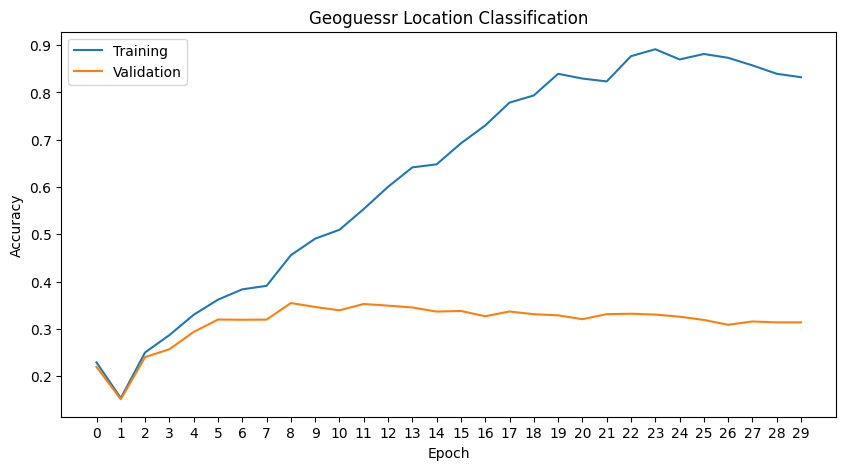

In [9]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Geoguessr Location Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()

In [13]:
def topk_eval(model, loader, k):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for input in tqdm(loader):
            batch, label = input['image'], input['label']
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            label = torch.reshape(label, (label.shape[0], 1))
            correct += (label == torch.topk(pred, k)[1]).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc

topk_eval(model, test_loader, k=5)

100%|██████████| 225/225 [00:05<00:00, 43.21it/s]


 Evaluation accuracy: 0.6388230372333008


0.6388230372333008